In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchmetrics
from PIL import Image
from tqdm import tqdm
from data.guided_diffusion.unet import create_model
from src.utils import *
from src.h_fcn import *
from src.pigdm import PIGDM
from src.eval import *
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda:0


In [2]:
model = init_model()

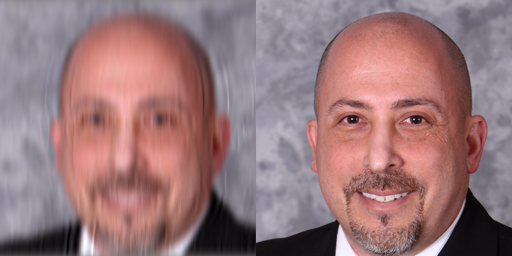

In [32]:
# First lets suppose the image is generated from a gaussian blurring with certain parameters

idx = 82
x_true_pil = Image.open('../data/ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(x_true_pil)


sigma_noise = 0

true_size, true_sigma = 25, 5

true_kernel = gaussian_kernel(true_size, true_sigma)

H = Blurring(true_kernel)


y = H(x_true)+ sigma_noise * torch.randn_like(x_true)

_ = display_as_pilimg(torch.concat((y, x_true), dim=3))

Sampling:   0%|          | 0/399 [00:00<?, ?it/s]/home/onyxia/work/Generative_Modeling_Project/src/pigdm.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_s = torch.tensor(self.alphas_cp_torch[si].cpu() if si != -1 else 1.0,


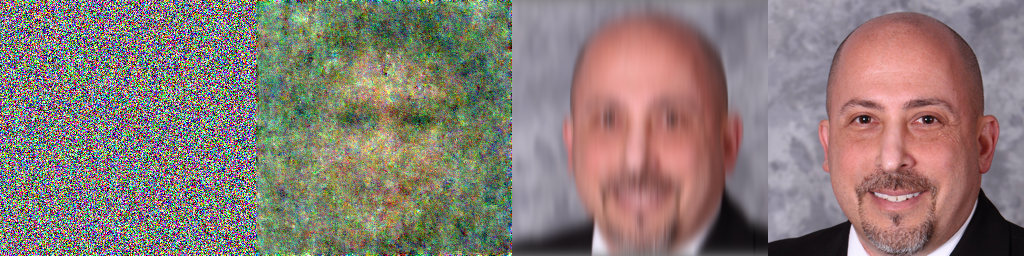

Sampling:  50%|█████     | 200/399 [01:52<01:39,  2.00it/s]

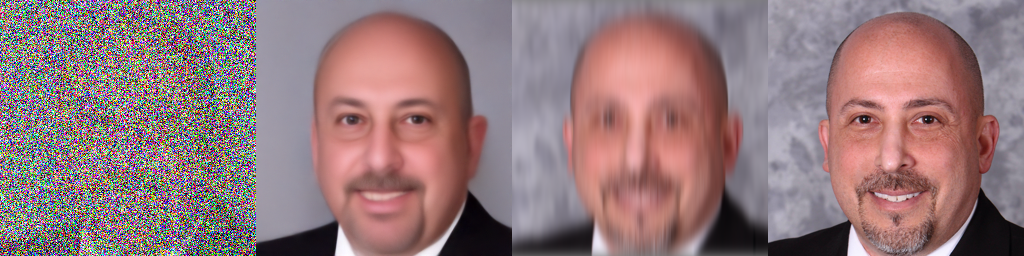

Sampling: 100%|██████████| 399/399 [03:52<00:00,  1.72it/s]


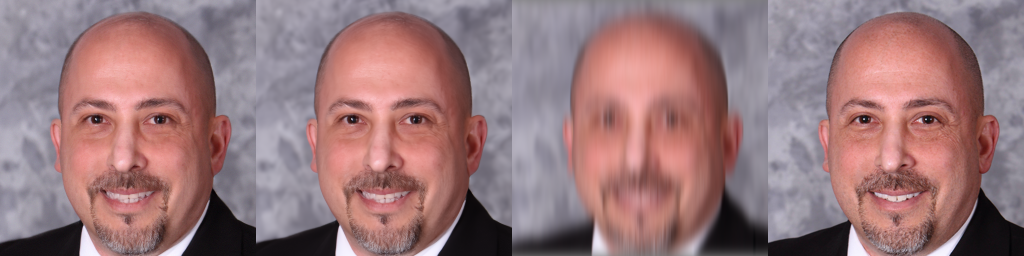

In [33]:
pgdm = PIGDM(model, 256, H, num_ddim_steps=400)

_ = pgdm.posterior_sampling(y, x_true=x_true, show_steps=True, vis_y=None, steps_viz=200)

In [ ]:
# the results are really good (almost perfects)
# now we can try to test when the kernel given to the model is not well estimated
# for example if sigma is too high, or size too long etc...

In [34]:
args = {
    "Sigma_U": [1, 25],  # under estimated sigma
    "Sigma_O": [10, 25],  # overestimated sigma
    "Size_U": [5, 35],  # size under estimated
    "Size_O": [5, 15],  # size overestimated
    "Sigma_U_Size_U": [1, 15],  # Sigma_U & Size_U
    "Sigma_U_Size_O": [1, 35],  # etc..
    "Sigma_O_Size_U": [10, 15],  # 
    "Sigma_O_Size_O": [10, 35],  # 
}

In [48]:
#results = {} # dic to store the results

for scenario in tqdm(args):
    kernel = gaussian_kernel(args[scenario][1], args[scenario][0]) # generate the badly estimated kernel
    H_emp = Blurring(kernel)  # plug it to H
    pgdm = PIGDM(model, 256, H_emp, num_ddim_steps=400) # initiate model

    xt_s, _ = pgdm.posterior_sampling(y, x_true=x_true, show_steps=False, vis_y=None) # run the model

    results[scenario] = xt_s[0]


  0%|          | 0/8 [00:00<?, ?it/s]/home/onyxia/work/Generative_Modeling_Project/src/pigdm.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_s = torch.tensor(self.alphas_cp_torch[si].cpu() if si != -1 else 1.0,
100%|██████████| 8/8 [31:58<00:00, 239.80s/it]


In [49]:
results.keys()

dict_keys(['Sigma_U', 'Sigma_O', 'Size_U', 'Size_O', 'Sigma_U_Size_U', 'Sigma_U_Size_O', 'Sigma_O_Size_U', 'Sigma_O_Size_O'])

100%|██████████| 8/8 [00:00<00:00, 107.01it/s]


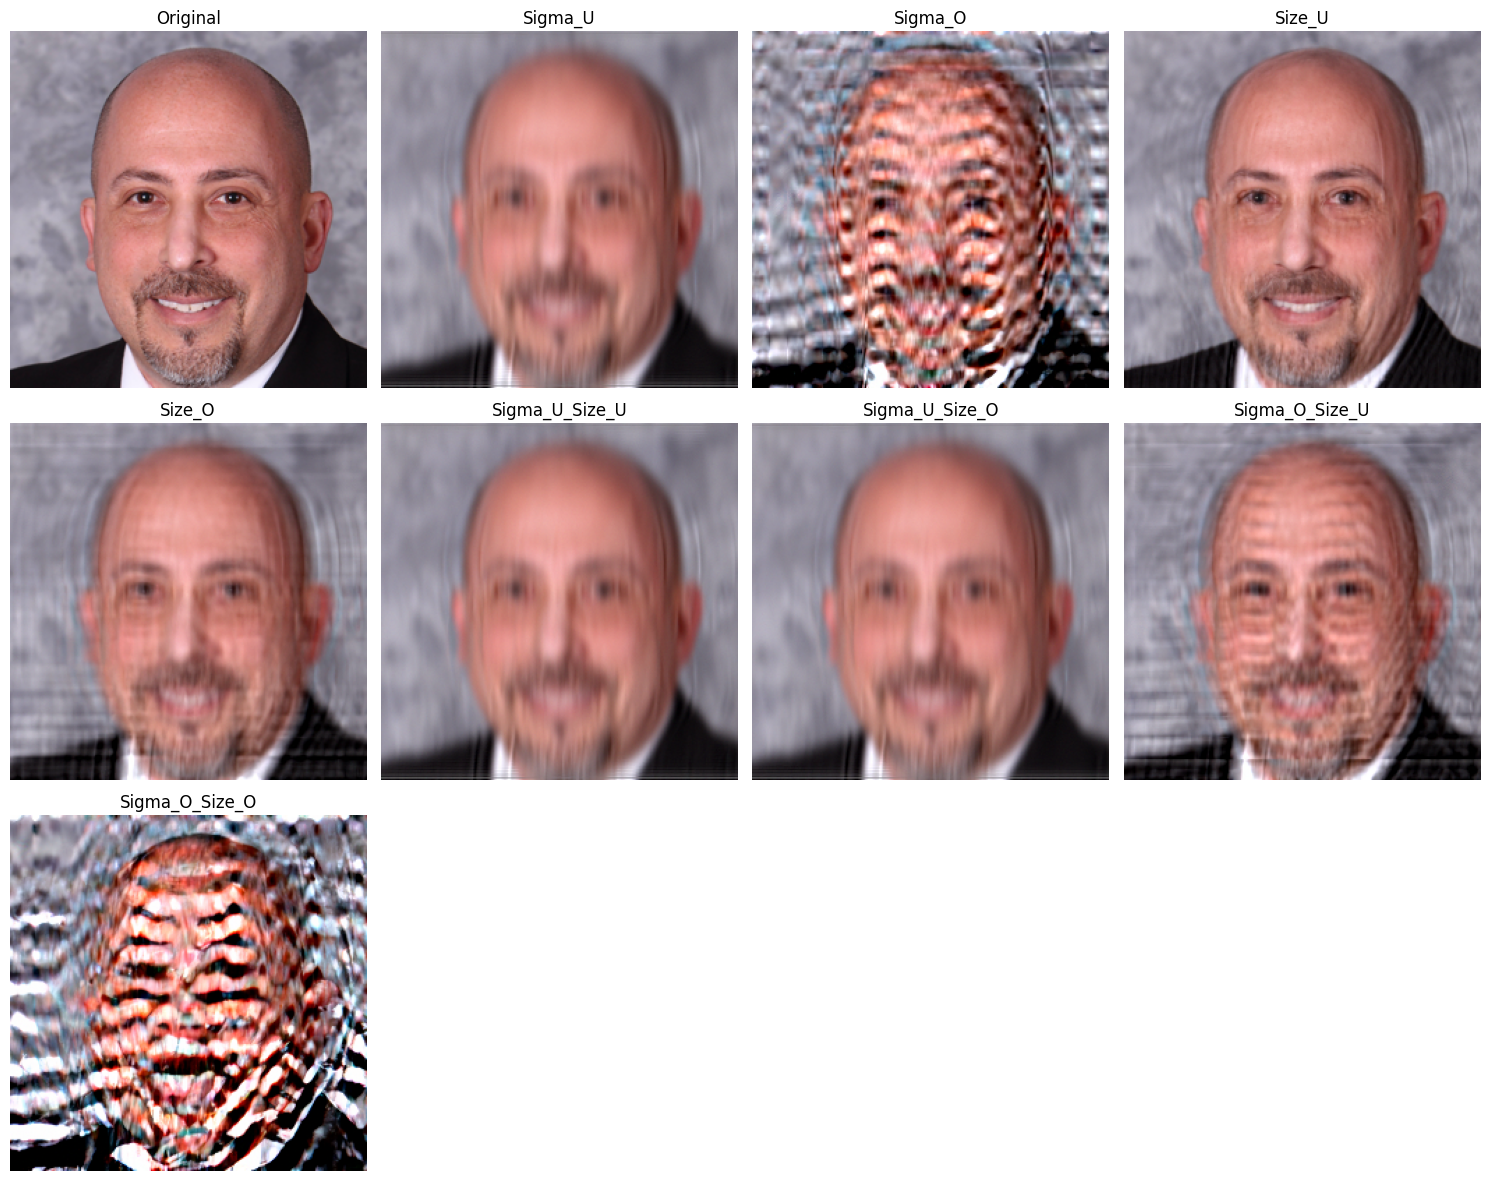

In [ ]:
def plot_scenarios(original_image, results):
    num_scenarios = len(results)
    num_cols = 4
    num_rows = (num_scenarios + 1) // num_cols + 1

    transform = transforms.ToPILImage()

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()

    axes[0].imshow(display_as_pilimg(original_image, show=False))
    axes[0].set_title("Original")
    axes[0].axis("off")

    for i, (scenario, tensor) in enumerate(tqdm(results.items()), start=1):
        img = display_as_pilimg(tensor, show=False)
        axes[i].imshow(img)
        axes[i].set_title(scenario)
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_scenarios(x_true.cpu(), results)

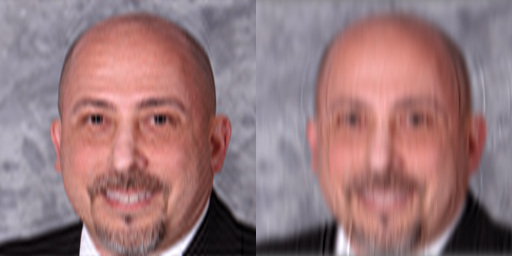

In [ ]:
# Here we can see that when H_pinv is well specified, we already have good results by just applying the pseudo
# inverse to the image
_ =display_as_pilimg(torch.concat((H.H_pinv(H(x_true)), y), dim=3))

In [61]:
# Now for an other experiment as suggested, we can try gaussian deblurring when we add a measurment noise

sigma_noise = 1

true_size, true_sigma = 15, 1

true_kernel = gaussian_kernel(true_size, true_sigma)

H = Blurring(true_kernel)


y = H(x_true)+ sigma_noise * torch.randn_like(x_true)

pgdm = PIGDM(model, 256, H, num_ddim_steps=400)

output, _ = pgdm.posterior_sampling(y, x_true=x_true, show_steps=False, vis_y=None, steps_viz=200)


Sampling:   0%|          | 0/399 [00:00<?, ?it/s]/home/onyxia/work/Generative_Modeling_Project/src/pigdm.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_s = torch.tensor(self.alphas_cp_torch[si].cpu() if si != -1 else 1.0,


Sampling: 100%|██████████| 399/399 [02:54<00:00,  2.28it/s]


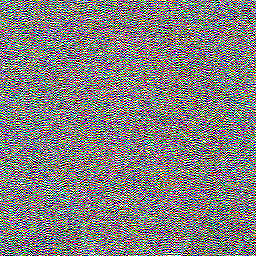

In [ ]:
c = display_as_pilimg(output[0])

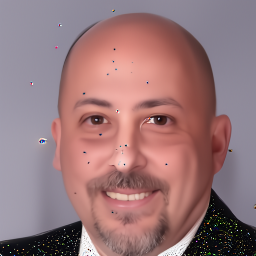

In [ ]:
ddim = DDIM(model, num_ddim_steps=400)

output, _ = ddim.posterior_sampling(linear_operator=H, y=y, x_true=x_true, show_steps=False, vis_y=None, eta=0.2, steps_viz=25)

c = display_as_pilimg(output[0])

# we can see here that DPS clearly perform way better than PIGDM when we add noise to the gaussian blur